In [1]:
from ultralytics import YOLO

model = YOLO("best.pt")

In [2]:
import torch
import cv2
import numpy as np

midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

Using cache found in C:\Users\navee/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\navee\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading weights:  None


Using cache found in C:\Users\navee/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\navee/.cache\torch\hub\intel-isl_MiDaS_master


In [3]:
image = cv2.imread("test.jpg")
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
input_batch = transform(img_rgb).to(device)

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()

In [5]:
results = model(image)

for r in results:
    boxes = r.boxes


0: 640x640 1 Dogs, 5.1ms
Speed: 12.3ms preprocess, 5.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


In [6]:
for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls = int(box.cls[0])
    label = model.names[cls]

    # Take center of bounding box
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    depth_value = depth_map[center_y, center_x]

    print(f"{label} - Depth value: {depth_value}")

Dogs - Depth value: 797.8243408203125


In [7]:
distance = 1 / (depth_value + 1e-6)

In [8]:
distance = 1 / (depth_value + 1e-6)

cv2.rectangle(image, (x1,y1), (x2,y2), (0,255,0), 2)
cv2.putText(image, f"{label} {distance:.2f}m",
            (x1, y1-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6, (0,255,0), 2)

array([[[  0,   0,   8],
        [206, 217, 225],
        [194, 207, 215],
        ...,
        [ 22,  34,  46],
        [ 22,  34,  46],
        [ 23,  35,  47]],

       [[  0,   1,   9],
        [211, 222, 230],
        [203, 216, 224],
        ...,
        [ 22,  34,  46],
        [ 22,  34,  46],
        [ 23,  35,  47]],

       [[  0,   0,   7],
        [211, 222, 230],
        [206, 219, 227],
        ...,
        [ 22,  34,  46],
        [ 22,  34,  46],
        [ 23,  35,  47]],

       ...,

       [[  0,   4,  15],
        [191, 209, 220],
        [185, 204, 217],
        ...,
        [143, 168, 178],
        [147, 172, 182],
        [150, 175, 185]],

       [[  0,   4,  15],
        [191, 209, 220],
        [185, 204, 217],
        ...,
        [138, 163, 173],
        [144, 169, 179],
        [149, 174, 184]],

       [[  0,   3,  14],
        [191, 209, 220],
        [185, 204, 217],
        ...,
        [131, 156, 166],
        [137, 162, 172],
        [143, 168, 178]]

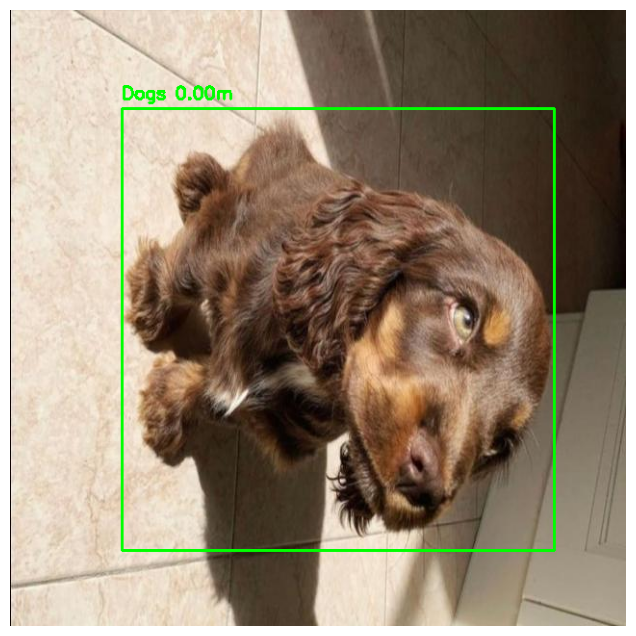

In [9]:
import matplotlib.pyplot as plt

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()